# TSP - Traveling Salesman Problem

In [76]:
import math
import copy
import time
import numpy as np

from collections import defaultdict

## Auxiliary methods

In [77]:
def import_dataset(path: str):
    """
    :param path: path to the dataset
    :return: numbers of vertexes, weight type, list of vertexes with tag and coordinates
    """
    lines = open(path, "r").read().split("\n")

    cont = 0
    dim, wt, v = 0, "", []
    while not lines[cont].startswith("NODE_COORD_SECTION"):
        if lines[cont].startswith("DIMENSION"):
            dim = int(lines[cont].split(":")[1][1:])
        elif lines[cont].startswith("EDGE_WEIGHT_TYPE"):
            wt = lines[cont].split(":")[1][1:]
        cont += 1
    cont += 1

    for i in range(cont, len(lines)):
        line = lines[i].split()
        if len(line) < 3: # Skip EOF
            break
        tag, x, y = int(line[0]) - 1, float(line[1]), float(line[2])
        v.append((tag, [x, y])) #(i, [x_value, y_value])

    return dim, wt, v

In [78]:
def weight (u, v):
    """
    :param u: vertex u
    :param v: vertex v
    :return: euclidean or geographical distance between u and v
    """
    if weight_type == "EUC_2D": # Euclidean distance
        return round(math.sqrt(sum([(a - b) ** 2 for a, b in zip(u, v)])))
    else: # Geographical distance
        PI = 3.141592
        deg_xu = int(u[0])
        min_xu = u[0] - deg_xu
        rad_xu = PI * (deg_xu + 5.0 * min_xu/ 3.0) / 180.0

        deg_yu = int(u[1])
        min_yu = u[1] - deg_yu
        rad_yu = PI * (deg_yu + 5.0 * min_yu/ 3.0) / 180.0

        deg_xv = int(v[0])
        min_xv = v[0] - deg_xv
        rad_xv= PI * (deg_xv + 5.0 * min_xv/ 3.0) / 180.0

        deg_yv = int(v[1])
        min_yv = v[1]- deg_yv
        rad_yv = PI * (deg_yv + 5.0 * min_yv/ 3.0) / 180.0

        RRR = 6378.388
        q1 = math.cos(rad_yu - rad_yv)
        q2 = math.cos(rad_xu - rad_xv)
        q3 = math.cos(rad_xu + rad_xv)
        return int(RRR * math.acos(0.5 * ((1.0 + q1) * q2 - (1.0 - q1) * q3)) + 1.0)

In [79]:
class Node:
    def __init__(self, tag: int):
        self.tag = tag
        self.key = None
        self.parent = None
        self.isPresent = True
        self.index = tag # Track the index of the node in the heap instead of using list.index() method which is O(n)
        self.adjacencyList = []

class Graph:
    def __init__(self):
        self.nodes = defaultdict(Node)

    def createNodes(self, nums: int):
        for i in range(0, nums): # nums+1 in order to cover the last node
            self.nodes[i] = Node(i)

    def addNode(self, tag:int, adjTag:int, adjCost):
        self.nodes[adjTag].adjacencyList.append([self.nodes[tag], adjCost]) # Graph is undirected

    def buildGraphTSP(self):
        self.createNodes(dimension)
        for v in vertexes:
            U = copy.deepcopy(vertexes)
            U.remove(v)
            for u in U:
                self.addNode(v[0], u[0], weight(v[1], u[1]))

In [80]:
class ArrayHeap(list):
    def __init__(self, array):
        super().__init__(array)
        self.heapSize = len(array)


class MinHeap:
    def __init__(self, array: list, root: Node):
        self.arrayHeap = ArrayHeap(array)
        # Check if the root node is not the first
        if self.arrayHeap[0] != self.arrayHeap[root.tag]:  # reset the starting node and update all indexes
            rootNode = self.arrayHeap[root.tag]
            self.arrayHeap.remove(rootNode)
            self.arrayHeap.insert(0, rootNode)
            for i in range(0, self.arrayHeap.heapSize):
                self.arrayHeap[i].index = i

    # All the following methods work with zero based array. Hence, we need to handle separately odd and even indexes.
    def parent(self, i: int):
        if i % 2 == 0:  # even
            return i // 2 - 1
        else:
            return i // 2

    def left(self, i):
        return 2 * i + 1

    def right(self, i):
        return 2 * i + 2

    # Execution time: O(lg n)
    def minHeapify(self, i: int):
        l = self.left(i)
        r = self.right(i)
        if l <= self.arrayHeap.heapSize - 1 and self.arrayHeap[l].key < self.arrayHeap[i].key:
            minimo = l
        else:
            minimo = i
        if r <= self.arrayHeap.heapSize - 1 and self.arrayHeap[r].key < self.arrayHeap[minimo].key:
            minimo = r
        if minimo != i:
            self.arrayHeap[i].index, self.arrayHeap[minimo].index = minimo, i  # Update indexes
            self.arrayHeap[i], self.arrayHeap[minimo] = self.arrayHeap[minimo], self.arrayHeap[i]
            self.minHeapify(minimo)

    def bubbleUp(self, index: int):
        parent = self.parent(index)
        current = index
        while current > 0 and self.arrayHeap[parent].key > self.arrayHeap[current].key:
            self.arrayHeap[current].index, self.arrayHeap[parent].index = parent, current  # Update indexes
            self.arrayHeap[current], self.arrayHeap[parent] = self.arrayHeap[parent], self.arrayHeap[current]
            current = parent
            parent = self.parent(parent)

    # Execution time: O(lg n)
    # First we update the heap structure, then we remove the last element.
    def extractMin(self):
        if self.arrayHeap.heapSize < 1:
            print("Error: extractMin underflow")
            return
        else:
            minimum = self.arrayHeap[0]  # Save the minimum node
            self.arrayHeap[0].isPresent = False  # Set its flag to false
            # Swap the first node and right most one
            self.arrayHeap[0], self.arrayHeap[self.arrayHeap.heapSize - 1] = self.arrayHeap[
                                                                                 self.arrayHeap.heapSize - 1], \
                                                                             self.arrayHeap[0]
            self.arrayHeap[0].index = 0  # Update its index
            self.arrayHeap.heapSize -= 1  # Decreasing heapsize
            self.minHeapify(0)  # Call minHeapify in order to move the new first node to the correct position

            return minimum

## Held and Karp algorithm

In [81]:
def encode(S):
    """
    :param S: set of vertexes S
    :return: unique string identifier for S, made joining the indexes of the vertexes with a blank space between them
    """
    encoded_string = ""
    for s in S:
      encoded_string += " " + str(s[0])
    return encoded_string

In [82]:
def held_karp (v, S, max_time):
    """
    :param v: arrival vertex of S starting from 0
    :param S: set of vertexes S
    :param max_time: maximum computation time 
    :return: minimum TSP distance
    """
    S_index = subsets[encode(S)] # build a unique identifier for the subset S
    if time.time() > max_time: # max time: 3 min
      return None
    elif (len(S) == 1) & (S[0][0] == v): # base case: the solution is the weight of the edge {v, 0}
      return weight(vertexes[v][1], vertexes[0][1])
    elif (v, S_index) in d: # distance already computed
      return d[(v, S_index)] 
    else:  # recursive case: find the minimum among all the sub-paths
      mindist = math.inf
      minprec = None
      subset = [i for i in S if i[0] != v] # S \ {v} 
      if encode(subset) not in subsets: 
        global counter
        subsets[encode(subset)] = counter
        counter += 1
      for u in subset:
        dist = held_karp(u[0], subset, max_time) # compute the partial result
        if dist is None:
          break
        else:
          w = weight(u[1], vertexes[v][1])
          if (dist + w) < mindist:
            mindist = dist + w
            minprec = u[0]
      d[(v, S_index)] = mindist # update d with the minimum distance
      phi[(v, S_index)] = minprec # update phi with predecessor of v
      return mindist

## Constructive heuristic algorithm with nearest neighbor

In [83]:
def closest_vertex(p, V: list):
    """
    :param p: last vertex of the partial path
    :param V: list of vertexes not added yet
    :return: the closest vertex to p and the distance between them
    """
    min_dist = math.inf
    closest = None
    for v in V:
        dist = weight(p[1], v[1])
        if dist < min_dist:
            min_dist = dist
            closest = v
    return closest, min_dist

In [84]:
def nearest_neighbor(V: list):
    """
    :param V: list of initial vertexes
    :return: TSP shortest path and its cost using Nearest Neighbor construcitve heuristic
    """
    starting_time = time.time()
    ''' Initialization '''
    unvisited = copy.deepcopy(V)      # Deep copy of V in order to maintain it unchanged
    starting_vertex = unvisited[0]    # Starting vertex
    partial_path = [starting_vertex]
    unvisited.remove(starting_vertex)
    total_dist = 0
    while len(unvisited) > 0:
        ''' Selection '''
        closest, dist = closest_vertex(partial_path[-1], unvisited)
        ''' Insertion '''
        partial_path.append(closest)
        unvisited.remove(closest)
        total_dist += dist
    total_dist += weight(partial_path[-1][1], starting_vertex[1])
    partial_path.append(starting_vertex) # Add the starting vertex to close the cycle
    end_time = time.time()
    return total_dist, '%.5f'%(end_time - starting_time)

## 2-approx algorithm

In [85]:
def two_approximation():

    g = Graph()
    g.buildGraphTSP()

    prim_solution = MSTPrim(g, g.nodes.get(0))

    parents = dict()
    for i in prim_solution.nodes.values():
        parents[i.tag] = i.parent.tag

    tree = mst_to_tree(parents)
    ham_cycle = preorder(tree, 0)
    ham_cycle.append(0)

    current_solution = ham_circ_weight(ham_cycle)

    return current_solution

In [86]:
def MSTPrim(g: Graph, r: Node):

    for node in g.nodes.values():
        node.key = math.inf # Set key. Parent is already set through Node constructor.
        node.parent = r

    r.key = 0

    q = MinHeap(list(g.nodes.values()), r) # Pass also the root node in order to build the heap starting from it

    while q.arrayHeap.heapSize != 0:
        u = q.extractMin()
        for v in u.adjacencyList:
            if v[0].isPresent and v[1] < v[0].key:
                v[0].parent = u
                v[0].key = v[1]
                q.bubbleUp(v[0].index) # bubbleUp maintains the minheap condition

    return g

In [87]:
def preorder(tree, u):

    if u not in tree:
        return [u]

    A = [u]
    for v in tree[u] :
        if v != u :
            A = A + preorder(tree, v)

    return A

In [88]:
def mst_to_tree(parents):

    if len(parents) == 0:
        return None

    if len(parents) == 1:
        nodo, padre = parents.popitem()
        return {padre: [nodo]}

    nodo, padre = parents.popitem()
    tree = mst_to_tree(parents)

    if padre in tree:
        tree[padre].append(nodo)
    else:
        tree[padre] = [nodo]

    return tree


In [89]:
def ham_circ_weight(ham_circ):

    total_weight = 0
    for j in range(1, len(ham_circ)):
        i = j - 1
        total_weight += weight(vertexes[ham_circ[i]][1], vertexes[ham_circ[j]][1])

    return total_weight

## Main

In [90]:
def execute_algs(dataset_name):
    print("-------------------------------------------------------------------")
    print("Executing Held Karp algorithm on {} dataset.".format(dataset_name))
    starting_time = time.time()
    max_time = 90
    held_karp_value = held_karp(0, vertexes, starting_time + max_time)
    held_karp_time = '%.5f'%(time.time() - starting_time)
    print("Best solution found in {} seconds : {}".format(held_karp_time, held_karp_value))

    print("Executing Nearest Neighbor algorithm on {} dataset.".format(dataset_name))
    nearest_neighbor_value, nearest_neighbor_time = nearest_neighbor(vertexes)
    print("Best solution found in {} seconds : {}".format(nearest_neighbor_time, nearest_neighbor_value))

    print("Executing 2-Approximation algorithm on {} dataset.".format(dataset_name))
    starting_time = time.time()
    two_approximation_value = two_approximation()
    two_approximation_time = '%.5f'%(time.time() - starting_time)
    print("Best solution found in {} seconds : {}".format(two_approximation_time, two_approximation_value))
    print()

    held_karp_error = '%.2f'%(((held_karp_value - inputs[dataset_name]) / inputs[dataset_name])*100)
    nearest_neighbor_error = '%.2f'%(((nearest_neighbor_value - inputs[dataset_name]) / inputs[dataset_name])*100)
    two_approximation_error = '%.2f'%(((two_approximation_value- inputs[dataset_name]) / inputs[dataset_name])*100)

    return [
            int(held_karp_value), held_karp_time, held_karp_error,
            nearest_neighbor_value, nearest_neighbor_time, nearest_neighbor_error,
            two_approximation_value, two_approximation_time, two_approximation_error
    ]

In [91]:
path= "tsp_dataset/"
results = []
inputs = {
    "burma14.tsp": 3323,
    "ulysses16.tsp": 6859,
    "ulysses22.tsp": 7013,
    "eil51.tsp": 426,
    "berlin52.tsp": 7542,
    "kroD100.tsp": 21294,
    "kroA100.tsp": 21282,
    "ch150.tsp": 6528,
    "gr202.tsp": 40160,
    "gr229.tsp": 134602,
    "pcb442.tsp": 50778 ,
    "d493.tsp": 35002,
    "dsj1000.tsp":18659688
}
for dataset_name in inputs.keys():
    dimension, weight_type, vertexes = import_dataset(path + dataset_name)
    # Held and Karp initialization section
    subsets = {} # Dictionary to enumerate the subsets
    counter = 0
    subsets[encode(vertexes)] = counter # Add the first subset, with all vertexes
    counter += 1
    d = {}
    phi = {}

    results.append(execute_algs(dataset_name))

-------------------------------------------------------------------
Executing Held Karp algorithm on burma14.tsp dataset.
Best solution found in 1.78971 seconds : 3323
Executing Nearest Neighbor algorithm on burma14.tsp dataset.
Best solution found in 0.00031 seconds : 4048
Executing 2-Approximation algorithm on burma14.tsp dataset.
Best solution found in 0.00146 seconds : 4003

-------------------------------------------------------------------
Executing Held Karp algorithm on ulysses16.tsp dataset.
Best solution found in 9.34773 seconds : 6859
Executing Nearest Neighbor algorithm on ulysses16.tsp dataset.
Best solution found in 0.00034 seconds : 9988
Executing 2-Approximation algorithm on ulysses16.tsp dataset.
Best solution found in 0.00197 seconds : 7788

-------------------------------------------------------------------
Executing Held Karp algorithm on ulysses22.tsp dataset.
Best solution found in 90.00008 seconds : 8110
Executing Nearest Neighbor algorithm on ulysses22.tsp datas

In [92]:
import pandas as pd
header = pd.MultiIndex.from_product([['Held-Karp','Nearest Neighbor','2-Approssimato'], ['Soluzione', 'Tempo (s)', 'Errore (%)']], names=['','Istanza'])
table_properties = {'font-size': '10pt','border-color': 'black','border-style' :'solid' ,'border-width': '1px','padding': '5px','text-align': 'center'}
header_properties = [{'selector': 'th', 'props': [('font-size', '10pt'),('padding-top', '5px'),('padding-bottom', '5px'),('padding-left', '10px'),('padding-right', '10px'),('border-color', 'black'),('border-style' ,'solid') ,('border-width', '1px')]}]

df = pd.DataFrame(results, index=inputs.keys(), columns=header).style.set_properties(**table_properties).set_table_styles(header_properties)
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


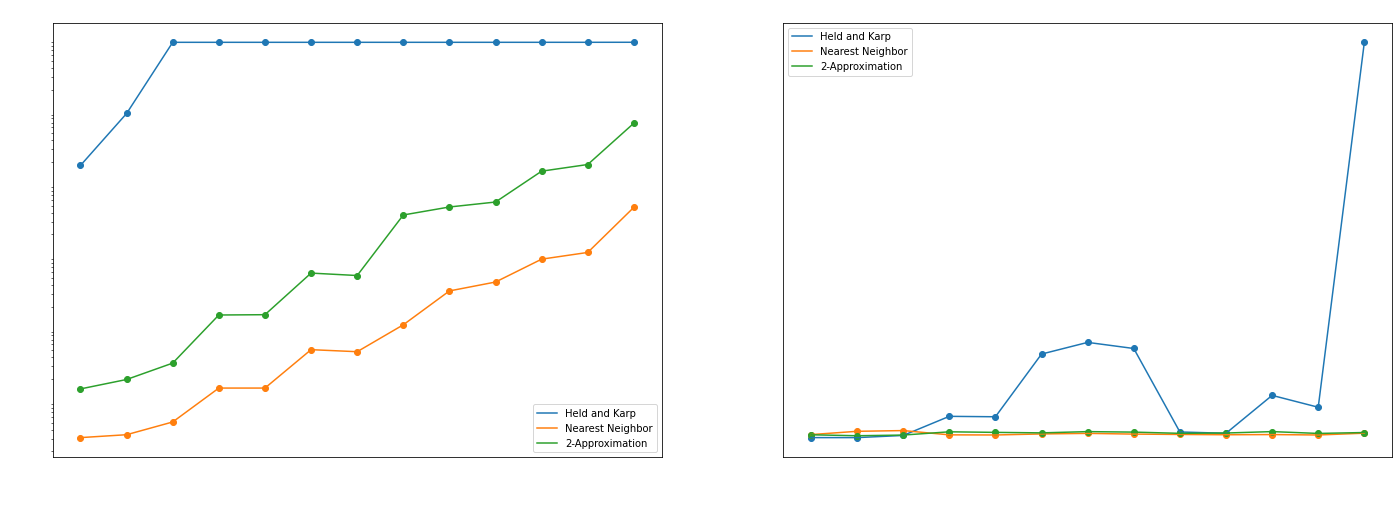

In [106]:
res_np=np.array(results, dtype="float64")

held_karp_times=res_np[:,1]
closest_times=res_np[:,4]
two_approximation_times=res_np[:,7]

held_karp_errors=res_np[:,2]
closest_errors=res_np[:,5]
two_approximation_errors=res_np[:,8]

import matplotlib.pylab as plt

fig, ax = plt.subplots(nrows=1, ncols=2)
ax1,ax2=ax

fig.set_figwidth(24)
fig.set_figheight(8)

ax1.plot(list(inputs), held_karp_times)
ax1.scatter(list(inputs), held_karp_times)
ax1.plot(list(inputs), closest_times)
ax1.scatter(list(inputs), closest_times)
ax1.plot(list(inputs), two_approximation_times)
ax1.scatter(list(inputs), two_approximation_times)

ax2.plot(list(inputs), held_karp_errors)
ax2.scatter(list(inputs), held_karp_errors)
ax2.plot(list(inputs), closest_errors)
ax2.scatter(list(inputs), closest_errors)
ax2.plot(list(inputs), two_approximation_errors)
ax2.scatter(list(inputs), two_approximation_errors)

ax1.set_xticklabels(list(inputs),rotation=45)
ax2.set_xticklabels(list(inputs),rotation=45)

ax1.legend(["Held and Karp", "Nearest Neighbor","2-Approximation"])
ax1.set_title("Running Times Comparison")
ax1.set_ylabel("Time in seconds")
ax1.set_yscale("log")

ax2.set_title("Error(%) Comparison")
ax2.legend(["Held and Karp", "Nearest Neighbor","2-Approximation"])
ax2.set_ylabel("Error(%)")

ax1.yaxis.label.set_color('white')
ax1.xaxis.label.set_color('white')
ax2.yaxis.label.set_color('white')
ax2.xaxis.label.set_color('white')
ax1.tick_params(axis='x', colors='white')
ax1.tick_params(axis='y', colors='white')
ax2.tick_params(axis='x', colors='white')
ax2.tick_params(axis='y', colors='white')
ax1.title.set_color('white')
ax2.title.set_color('white')

ax3.plot(list(inputs), held_karp_errors)
ax3.scatter(list(inputs), held_karp_errors)
ax3.plot(list(inputs), closest_errors)
ax3.scatter(list(inputs), closest_errors)
ax3.plot(list(inputs), two_approximation_errors)
ax3.scatter(list(inputs), two_approximation_errors)
ax3.set_xticklabels(list(inputs),rotation=45)
ax3.set_title("Error(%) Comparison")
ax3.legend(["Held and Karp", "Nearest Neighbor","2-Approximation"])
ax3.set_yscale("log")
ax3.set_ylabel("Error(%)")

ax3.yaxis.label.set_color('white')
ax3.xaxis.label.set_color('white')
ax3.tick_params(axis='x', colors='white')
ax3.tick_params(axis='y', colors='white')
ax3.title.set_color('white')



fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


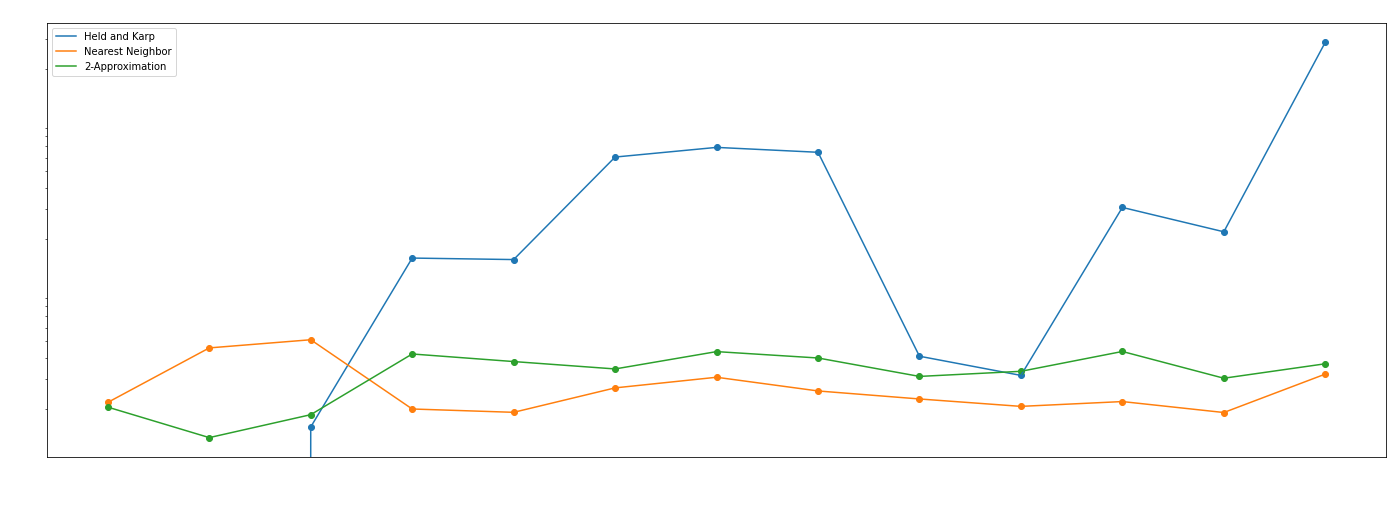

In [107]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax3=ax

fig.set_figwidth(24)
fig.set_figheight(8)

ax3.plot(list(inputs), held_karp_errors)
ax3.scatter(list(inputs), held_karp_errors)
ax3.plot(list(inputs), closest_errors)
ax3.scatter(list(inputs), closest_errors)
ax3.plot(list(inputs), two_approximation_errors)
ax3.scatter(list(inputs), two_approximation_errors)
ax3.set_xticklabels(list(inputs),rotation=45)
ax3.set_title("Error(%) Comparison")
ax3.legend(["Held and Karp", "Nearest Neighbor","2-Approximation"])
ax3.set_yscale("log")
ax3.set_ylabel("Error(%)")

ax3.yaxis.label.set_color('white')
ax3.xaxis.label.set_color('white')
ax3.tick_params(axis='x', colors='white')
ax3.tick_params(axis='y', colors='white')
ax3.title.set_color('white')

fig.show()